In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import lax
from jax import jit
from functools import partial

In [2]:
# from jax._numpy.ufuncs import (  # noqa: F401
#   abs, absolute, add, arccos, arccosh, arcsin, arcsinh, arctan, arctan2, arctanh,
#   bitwise_and, bitwise_not, bitwise_or, bitwise_xor, cbrt, ceil, conj, conjugate,
#   copysign, cos, cosh, deg2rad, degrees, divide, divmod, equal, exp, exp2, expm1,
#   fabs, float_power, floor, floor_divide, fmod, frexp, greater, greater_equal,
#   heaviside, hypot, imag, invert, isfinite, isinf, isnan, isneginf, isposinf,
#   ldexp, left_shift, less, less_equal, log, log10, log1p, log2, logaddexp, logaddexp2,
#   logical_and, logical_not, logical_or, logical_xor, maximum, minimum, mod, modf,
#   multiply, negative, nextafter, not_equal, positive, power, rad2deg, radians, real,
#   reciprocal, remainder, right_shift, rint, sign, signbit, sin, sinc, sinh, sqrt,
#   square, subtract, tan, tanh, true_divide)
# from jax.numpy.util import (  # noqa: F401
#   _arraylike, _broadcast_arrays, _broadcast_to, _check_arraylike,
#   _complex_elem_type, _promote_args, _promote_args_inexact, _promote_dtypes,
#   _promote_dtypes_numeric, _promote_dtypes_inexact, _promote_shapes,
#   _register_stackable, _stackable, _where, _wraps)

@jit
def lin_interp(x, xp, fp,side='right'):
#     jnp._check_arraylike("interp", x, xp, fp)
#     if jnp.shape(xp) != jnp.shape(fp) or jnp.ndim(xp) != 1:
#         raise ValueError("xp and fp must be one-dimensional arrays of equal size")
        
#     x, xp = jnp._promote_dtypes_inexact(x, xp)
#     fp, = jnp._promote_dtypes_inexact(fp)

#     if jnp.dtypes.issubdtype(x.dtype, np.complexfloating):
#         raise ValueError("jnp.interp: complex x values not supported.")
    
#     xp, fp = lax.sort_key_val(xp, fp)
#     xp = jnp.concatenate([xp[-1:] - period, xp, xp[:1] + period])
#     fp = jnp.concatenate([fp[-1:], fp, fp[:1]])

    i = jnp.clip(jnp.searchsorted(xp, x, side=side), 1, len(xp) - 1)
    df = fp[i] - fp[i - 1]
    dx = xp[i] - xp[i - 1]
    delta = x - xp[i - 1]

    epsilon = np.spacing(np.finfo(xp.dtype).eps)
    dx0 = lax.abs(dx) <= epsilon  # Prevent NaN gradients when `dx` is small.
    f = jnp.where(dx0, fp[i - 1], fp[i - 1] + (delta / jnp.where(dx0, 1, dx)) * df)

    return f

In [3]:
def gaussian(x,mu,sigma):
    return np.exp(-(x - mu)**2/(2 * sigma**2)) #/ (2 * sigma * np.sqrt(2 * np.pi))

In [4]:
x = np.linspace(0,3)
y = np.ones(x.shape)
y -= gaussian(x,1.5,1/16)

x_grid = np.linspace(1,2,500)
y_grid = lin_interp(x_grid,x,y)

2022-10-04 16:30:35.906513: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2022-10-04 16:30:35.906549: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


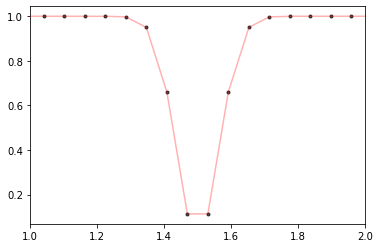

In [5]:
plt.plot(x,y,'.k',alpha=0.7)
plt.plot(x_grid,y_grid,'-r',alpha=0.3,zorder=3)
plt.xlim(1,2)
plt.show()

In [6]:
@partial(jit,static_argnames='a')
def lanczos(x,a):
    return jnp.where(jnp.abs(x) < a, 
                     jnp.sinc(jnp.pi*x) * jnp.sinc(jnp.pi*x/a), 0)

In [7]:
x_grid = np.linspace(-3,3,200)
y_grid = lanczos(x_grid,a=4)

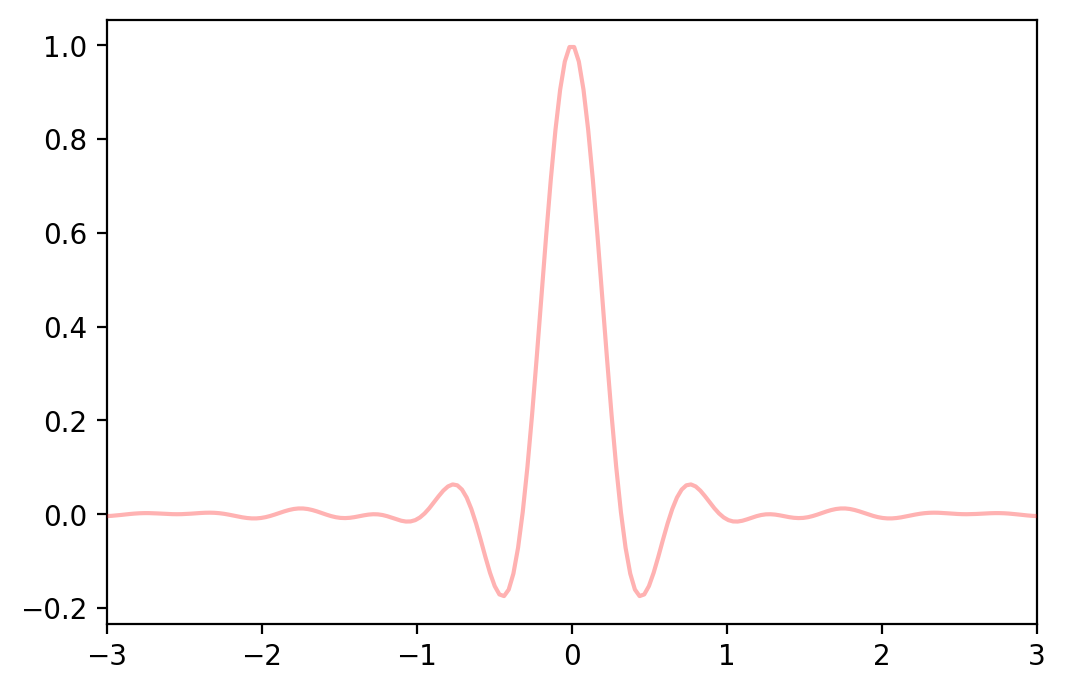

In [8]:
plt.figure(facecolor=(1,1,1),dpi=200)
plt.plot(x_grid,y_grid,'-r',alpha=0.3,zorder=3)
plt.xlim(-3,3)
plt.savefig('../out/lanczo_kernel.png')
plt.show()

In [9]:
# @_wraps(np.outer, skip_params=['out'])
@partial(jit, inline=True)
def outer_add(a, b, out=None):
    if out is not None:
        raise NotImplementedError("The 'out' argument to jnp.outer is not supported.")
        #   a, b = _promote_dtypes(a, b)
    return jnp.ravel(a)[:, None] + jnp.ravel(b)[None, :]

In [10]:
vec1 = jnp.ones((10))
vec2 = jnp.arange(12)
vec3 = outer_add(vec1,vec2)

In [11]:
print(vec1.shape,vec2.shape,vec3.shape)
print(type(vec3))

(10,) (12,) (10, 12)
<class 'jaxlib.xla_extension.DeviceArray'>


In [12]:
import scipy.sparse

In [13]:
@partial(jit,static_argnames=['dx','basis','a','side'])
def general_interp_fast(x, xp, fp, basis, a,side='left'):
#     jnp._check_arraylike("interp", x, xp, fp)
#     if jnp.shape(xp) != jnp.shape(fp) or jnp.ndim(xp) != 1:
#         raise ValueError("xp and fp must be one-dimensional arrays of equal size")
        
# #     x, xp = jnp._promote_dtypes_inexact(x, xp)
# #     fp, = jnp._promote_dtypes_inexact(fp)

#     if jnp.dtypes.issubdtype(x.dtype, np.complexfloating):
#         raise ValueError("jnp.interp: complex x values not supported.")
    
#     xp, fp = lax.sort_key_val(xp, fp)
#     xp = jnp.concatenate([xp[-1:] - period, xp, xp[:1] + period])
#     fp = jnp.concatenate([fp[-1:], fp, fp[:1]])
#     dx = # GET EXACT SPACING from XP
    i = jnp.clip(jnp.searchsorted(xp, x, side=side), 1, len(xp) - 1)
    b_width = np.arange(-a-1,a+1,step=1,dtype=int)
    delta = (x - xp[i - 1])/dx

    f_inds = outer_add(i,b_width).astype(int)
#     print(f_inds.shape)
    temp = outer_add(delta,b_width)
#     print(jnp.min(temp),jnp.max(temp))
    
    f = ( fp[f_inds] * basis(temp, a) ).sum(axis=1)
#     print(f.shape)
    
    return f

In [14]:
# dx = 0.1
# x  = np.arange(0,3,step=dx)
# y = np.zeros(x.shape)
# # y -= gaussian(x,1.5,1/16)
# y[y.shape[0]//2] = 0.88

# x_grid = np.linspace(0,3,1000)
# y_grid = general_interp_simple(x_grid,x,y,basis=lanczos,a=6)

In [15]:
# plt.figure(facecolor=(1,1,1),dpi=200)
# plt.plot(x,y,'.k',alpha=0.7)
# plt.plot(x_grid,y_grid,'-r',alpha=0.3,zorder=3)
# plt.xlim(0,3)
# plt.savefig('../out/lanczos_jax_interp.png')
# plt.show()

In [16]:
def alpha_recursion(i,j,p):
    # fixed values
    if i < 0 or i > p:
        return 0
    if j < 0 or j > p:
        return 0
    if p == 0:
        return 1
    # recursion
    return  (j/p) * alpha_recursion(i,j,p-1) +\
            (1/p) * alpha_recursion(i-1,j,p-1) +\
            ((p+1-j)/p) * alpha_recursion(i,j-1,p-1) -\
            (1/p) * alpha_recursion(i-1,j-1,p-1)

In [17]:
class BSpline:
    def __init__(self,p):
        # calculate coefficients of basis spline functions(piecewise polynomial)
        # p piecewise functions with p+1 terms
#         p = p.astype(int)
        p = int(p)
        self.p = p
        self.alphas = np.zeros((p+1,p+1))
        for i in range(p+1):
            for j in range(p+1):
                self.alphas[i,j] = alpha_recursion(i,j,p)
        self.alphas = jnp.array(self.alphas)
        
    @partial(jit,static_argnums=[0])
    def __call__(self,x,*args):
        # Recentering 
        i = jnp.floor(x + (self.p+1) / 2).astype(int)
        cond1 = i >= 0
        cond2 = i <= self.p
        f = jnp.where((cond1 * cond2), \
                      jnp.polyval(self.alphas[::-1,i], (x + (self.p+1) / 2) % 1), \
                      0.0)
        return f

In [18]:
from matplotlib.colors import LogNorm

In [39]:
@jit
def levinson(a, b):
    """Solve a linear Toeplitz system using Levinson recursion.
    Parameters
    ----------
    a : array, dtype=double or complex128, shape=(2n-1,)
        The first column of the matrix in reverse order (without the diagonal)
        followed by the first (see below)
    b : array, dtype=double  or complex128, shape=(n,)
        The right hand side vector. Both a and b must have the same type
        (double or complex128).
    Notes
    -----
    For example, the 5x5 toeplitz matrix below should be represented as
    the linear array ``a`` on the right ::
        [ a0    a1   a2  a3  a4 ]
        [ a-1   a0   a1  a2  a3 ]
        [ a-2  a-1   a0  a1  a2 ] -> [a-4  a-3  a-2  a-1  a0  a1  a2  a3  a4]
        [ a-3  a-2  a-1  a0  a1 ]
        [ a-4  a-3  a-2  a-1 a0 ]
    Returns
    -------
    x : arrray, shape=(n,)
        The solution vector
    reflection_coeff : array, shape=(n+1,)
        Toeplitz reflection coefficients. When a is symmetric Toeplitz and
        ``b`` is ``a[n:]``, as in the solution of autoregressive systems,
        then ``reflection_coeff`` also correspond to the partial
        autocorrelation function.
    """
    # Adapted from toeplitz.f90 by Alan Miller, accessed at
    # http://jblevins.org/mirror/amiller/toeplitz.f90
    # Released under a Public domain declaration.

    dtype = a.dtype
#     if dz is float64_t:
#         dtype = float64
#     else:
#         dtype = complex128

#     cdef ssize_t n, m, j, nmj, k, m2
    n = b.shape[0]
#     cdef dz x_num, g_num, h_num, x_den, g_den
#     cdef dz gj, gk, hj, hk, c1, c2
    x = np.zeros(n, dtype=dtype) 
    g = np.zeros(n, dtype=dtype)
    h = np.zeros(n, dtype=dtype)
    reflection_coeff = np.zeros(n+1, dtype=dtype)
#     cdef dz[:]  # result
#     cdef dz[:]   # workspace
#     cdef dz[:]   # workspace
#     cdef dz[:]   # history
    assert len(a) == (2*n) - 1

#     if a[n-1] == 0:
#         raise LinAlgError('Singular principal minor')
#     print(a[n-1],b[0])
    x[0] = b[0] / a[n-1]
    reflection_coeff[0] = 1
    reflection_coeff[1] = x[0]

    if (n == 1):
        return jnp.asarray(x), jnp.asarray(reflection_coeff)

    g[0] = a[n-2] / a[n-1]
    h[0] = a[n] / a[n-1]

    for m in range(1, n):
        # Compute numerator and denominator of x[m]
        x_num = -b[m]
        x_den = -a[n-1]
        for j in range(m):
            nmj = n + m - (j+1)
            x_num = x_num + a[nmj] * x[j]
            x_den = x_den + a[nmj] * g[m-j-1]
        if x_den == 0:
            raise LinAlgError('Singular principal minor')
        x[m] = x_num / x_den
        reflection_coeff[m+1] = x[m]

        # Compute x
        for j in range(m):
            x[j] = x[j] - x[m] * g[m-j-1]
        if m == n-1:
            return jnp.asarray(x), jnp.asarray(reflection_coeff)

        # Compute the numerator and denominator of g[m] and h[m]
        g_num = -a[n-m-2]
        h_num = -a[n+m]
        g_den = -a[n-1]
        for j in range(m):
            g_num = g_num + a[n+j-m-1] * g[j]
            h_num = h_num + a[n+m-j-1] * h[j]
            g_den = g_den + a[n+j-m-1] * h[m-j-1]

        if g_den == 0.0:
            raise LinAlgError("Singular principal minor")

        # Compute g and h
        g[m] = g_num / g_den
        h[m] = h_num / x_den
        k = m - 1
        m2 = (m + 1) >> 1
        c1 = g[m]
        c2 = h[m]
        for j in range(m2):
            gj = g[j]
            gk = g[k]
            hj = h[j]
            hk = h[k]
            g[j] = gj - (c1 * hk)
            g[k] = gk - (c1 * hj)
            h[j] = hj - (c2 * gk)
            h[k] = hk - (c2 * gj)
            k -= 1

In [40]:
@partial(jit,static_argnames=['check_finite'])
def solve_toeplitz(c, r, b, check_finite=True):
    """Solve a Toeplitz system using Levinson Recursion
    The Toeplitz matrix has constant diagonals, with c as its first column
    and r as its first row. If r is not given, ``r == conjugate(c)`` is
    assumed.
    Parameters
    ----------
    c_or_cr : array_like or tuple of (array_like, array_like)
        The vector ``c``, or a tuple of arrays (``c``, ``r``). Whatever the
        actual shape of ``c``, it will be converted to a 1-D array. If not
        supplied, ``r = conjugate(c)`` is assumed; in this case, if c[0] is
        real, the Toeplitz matrix is Hermitian. r[0] is ignored; the first row
        of the Toeplitz matrix is ``[c[0], r[1:]]``. Whatever the actual shape
        of ``r``, it will be converted to a 1-D array.
    b : (M,) or (M, K) array_like
        Right-hand side in ``T x = b``.
    check_finite : bool, optional
        Whether to check that the input matrices contain only finite numbers.
        Disabling may give a performance gain, but may result in problems
        (result entirely NaNs) if the inputs do contain infinities or NaNs.
    Returns
    -------
    x : (M,) or (M, K) ndarray
        The solution to the system ``T x = b``. Shape of return matches shape
        of `b`.
    See Also
    --------
    toeplitz : Toeplitz matrix
    Notes
    -----
    The solution is computed using Levinson-Durbin recursion, which is faster
    than generic least-squares methods, but can be less numerically stable.
    Examples
    --------
    Solve the Toeplitz system T x = b, where::
            [ 1 -1 -2 -3]       [1]
        T = [ 3  1 -1 -2]   b = [2]
            [ 6  3  1 -1]       [2]
            [10  6  3  1]       [5]
    To specify the Toeplitz matrix, only the first column and the first
    row are needed.
    >>> c = np.array([1, 3, 6, 10])    # First column of T
    >>> r = np.array([1, -1, -2, -3])  # First row of T
    >>> b = np.array([1, 2, 2, 5])
    >>> from scipy.linalg import solve_toeplitz, toeplitz
    >>> x = solve_toeplitz((c, r), b)
    >>> x
    array([ 1.66666667, -1.        , -2.66666667,  2.33333333])
    Check the result by creating the full Toeplitz matrix and
    multiplying it by `x`.  We should get `b`.
    >>> T = toeplitz(c, r)
    >>> T.dot(x)
    array([ 1.,  2.,  2.,  5.])
    """
    # If numerical stability of this algorithm is a problem, a future
    # developer might consider implementing other O(N^2) Toeplitz solvers,
    # such as GKO (https://www.jstor.org/stable/2153371) or Bareiss.

    
#     r, c, b, dtype, b_shape = _validate_args_for_toeplitz_ops(
#         c_or_cr, b, check_finite, keep_b_shape=True)

    # Form a 1-D array of values to be used in the matrix, containing a
    # reversed copy of r[1:], followed by c.
    vals = jnp.concatenate((r[-1:0:-1], c))
    if b is None:
        raise ValueError('illegal value, `b` is a required argument')

    if b.ndim == 1:
        x, _ = levinson(vals, b)
    else:
        x = jnp.column_stack([levinson(vals, b[:, i])[0]
                             for i in range(b.shape[1])])
        x = x.reshape(*b_shape)

    return x

In [21]:
def _sparse_design_matrix(x,xp,dx,basis,a):
    '''Internal Function for general_interp_simple
    to do: 
    make sparse using 'a' and fast
    choose fast sparse encoding
    the fastest for lstsq solve
    time all'''
    a_width = np.arange(-a-1,a+1,step=1,dtype=int)
    
    return basis((x[None,:] - xp[:,None])/dx)
    
def _toeplitz_design_matrix(xp,basis,a):
    '''
    Parameters:
    xp: even spaced values to evaluate basis function at
    a: length scale that basis goes to zero
    
    if basis is symmetric only need to evaluate one side of this function
    '''
    c_width = np.arange(0,-a-2,step=-1,dtype=int)
    r_width = np.arange(0,a+2,step=1,dtype=int)
    cc, rr = basis(c_width), basis(r_width)
    
    c, r = jnp.concatenate((cc,jnp.zeros((xp.shape[0]-a-2)))), \
            jnp.concatenate((rr,jnp.zeros((xp.shape[0]-a-2))))
    return c, r
   
@partial(jit,static_argnames=['basis','a'])
def general_interp_loose(x, xp, ap, basis, a):
    '''XP must be equally spaced
    deal boundary conditions 0D, 0N
    padding points
    with user inputs values
    
    for future test for a, where basis function goes to zero'''
    dx = xp[1] - xp[0]# GET EXACT SPACING from XP
#     assert jnp.allclose(xp[1:] - xp[:-1],dx) # require uniform spacing
#     X    = _sparse_design_matrix(xp,xp,dx,basis,a)

    # This is a toeplitz matrix solve, may be faster also sparse
    # make sparse scipy jax function maybe
#     alphas,res,rank,s = jnp.linalg.lstsq(X,fp)
    
    return (ap[:,None] * _sparse_design_matrix(x,xp,dx,basis,a)).sum(axis=0)


    
@partial(jit,static_argnames=['basis','a'])
def general_interp_simple(x, xp, fp, basis, a):
    '''XP must be equally spaced
    deal boundary conditions 0D, 0N
    padding points
    with user inputs values
    
    for future test for a, where basis function goes to zero'''
    dx = xp[1] - xp[0]# GET EXACT SPACING from XP
#     assert jnp.allclose(xp[1:] - xp[:-1],dx) # require uniform spacing
    X    = _sparse_design_matrix(xp,xp,dx,basis,a)

    # This is a toeplitz matrix solve, may be faster also sparse
    # make sparse scipy jax function maybe
    alphas,res,rank,s = jnp.linalg.lstsq(X,fp)
    
    return (alphas[:,None] * _sparse_design_matrix(x,xp,dx,basis,a)).sum(axis=0)

def general_interp_toeplitz(x, xp, fp, basis, a):
    '''XP must be equally spaced
    deal boundary conditions 0D, 0N
    padding points
    with user inputs values
    
    for future test for a, where basis function goes to zero'''
    dx = xp[1] - xp[0]# GET EXACT SPACING from XP
#     assert jnp.allclose(xp[1:] - xp[:-1],dx) # require uniform spacing
    c, r = _toeplitz_design_matrix(xp,basis,a)

    # This is a toeplitz matrix solve, may be faster also sparse
    # make sparse scipy jax function maybe
    alphas = scipy.linalg.solve_toeplitz(c,fp)
    
    return (alphas[:,None] * _sparse_design_matrix(x,xp,dx,basis,a)).sum(axis=0)

def general_interp_toeplitz_jax(x, xp, fp, basis, a):
    '''XP must be equally spaced
    deal boundary conditions 0D, 0N
    padding points
    with user inputs values
    
    for future test for a, where basis function goes to zero'''
    dx = xp[1] - xp[0]# GET EXACT SPACING from XP
#     assert jnp.allclose(xp[1:] - xp[:-1],dx) # require uniform spacing
    c, r = _toeplitz_design_matrix(xp,basis,a)

    # This is a toeplitz matrix solve, may be faster also sparse
    # make sparse scipy jax function maybe
    alphas = solve_toeplitz(c,r,fp)
    
    return (alphas[:,None] * _sparse_design_matrix(x,xp,dx,basis,a)).sum(axis=0)

In [22]:
bspline_order = 3
lin_spline = BSpline(bspline_order)

In [23]:
lin_spline.alphas

DeviceArray([[ 0.0000000e+00,  1.6666667e-01,  6.6666669e-01,
               1.6666667e-01],
             [ 0.0000000e+00,  5.0000000e-01, -2.7755576e-17,
              -5.0000000e-01],
             [ 0.0000000e+00,  5.0000000e-01, -1.0000000e+00,
               5.0000000e-01],
             [ 1.6666667e-01, -5.0000000e-01,  5.0000000e-01,
              -1.6666667e-01]], dtype=float32)

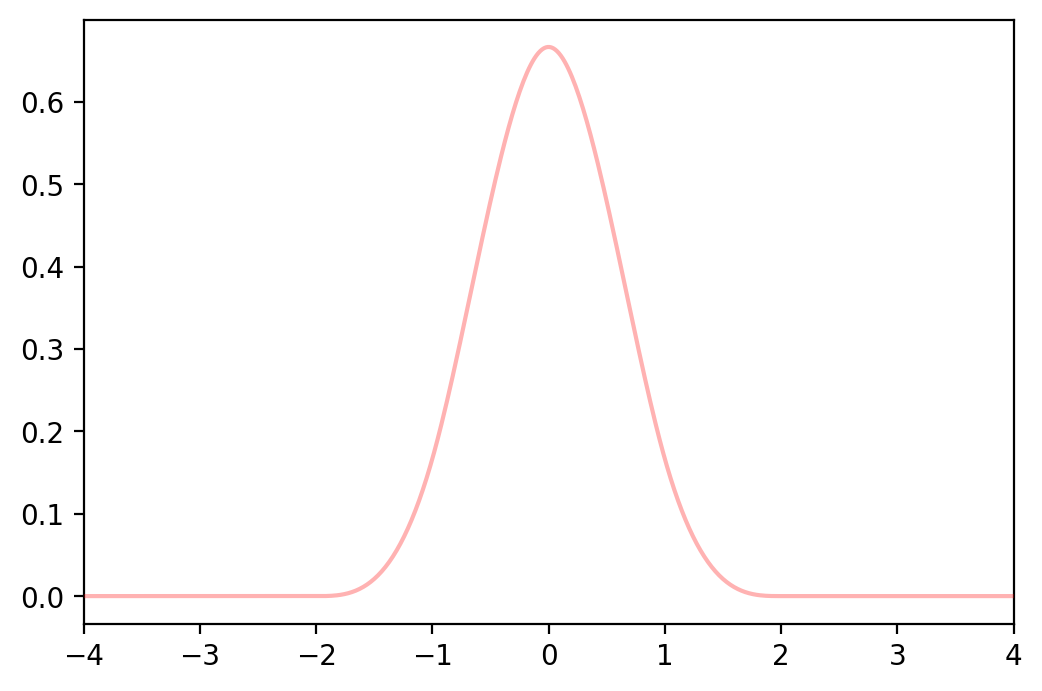

In [24]:
x_grid = np.linspace(-4,4,500)
y_grid = lin_spline(x_grid)
plt.figure(facecolor=(1,1,1),dpi=200)
plt.plot(x_grid,y_grid,'-r',alpha=0.3,zorder=3)
plt.xlim(-4,4)
plt.savefig('../out/bspline{}_kernel.png'.format(bspline_order))
plt.show()

In [25]:
dx = 0.1
x = np.arange(0,3,step=dx)
y = np.zeros(x.shape)
y -= gaussian(x,1.5,1/8)
y -= np.random.normal(0,1/200,size=y.shape[0])
# y[:] = 0.88

x_grid = np.linspace(0,3,1000)
y_grid = general_interp_simple(x_grid,x,y,basis=lin_spline,a=bspline_order)

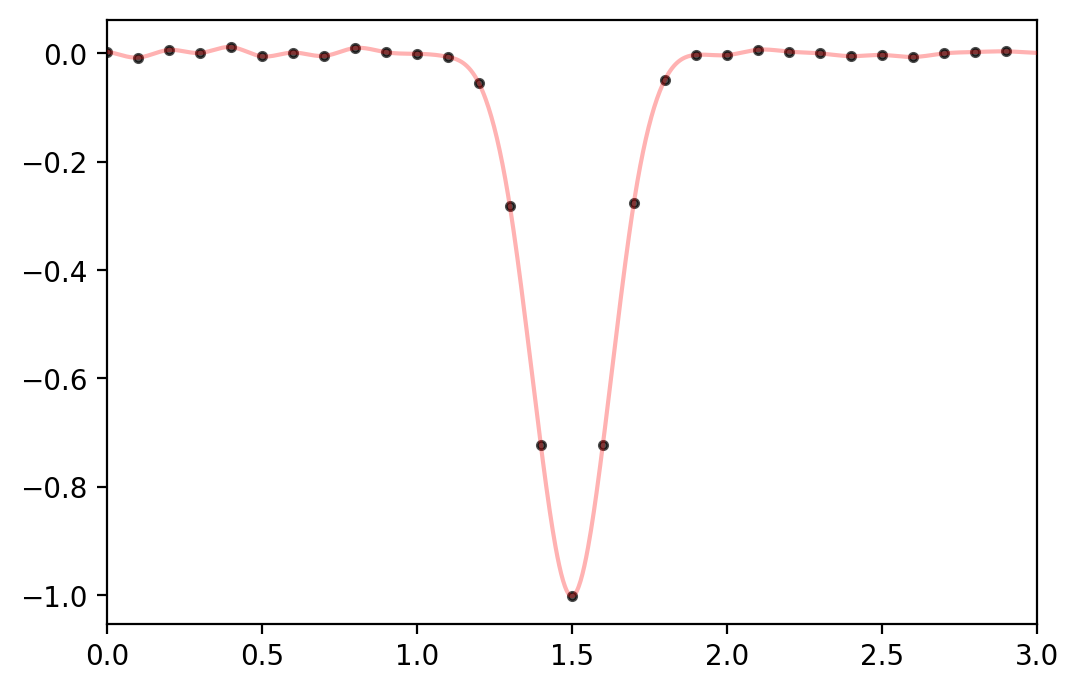

In [26]:
plt.figure(facecolor=(1,1,1),dpi=200)
plt.plot(x,y,'.k',alpha=0.7)
plt.plot(x_grid,y_grid,'-r',alpha=0.3,zorder=3)
plt.xlim(0,3)
plt.savefig('../out/bspline{}_interp.png'.format(bspline_order))
plt.show()

In [35]:
dx = 0.1
x_distance = 200
x = np.arange(0,x_distance,step=dx)
y = np.zeros(x.shape)
n_peaks = 50
for i in range(n_peaks):
    position = np.random.uniform(0,x_distance)
    y -= gaussian(x,position,1/8)
    y -= np.random.normal(0,1/200,size=y.shape[0])
    
x_grid = np.linspace(0,x_distance,1000)

In [36]:
%time y_grid = general_interp_simple(x_grid,x,y,basis=lin_spline,a=bspline_order)

CPU times: user 3.93 s, sys: 1.92 s, total: 5.85 s
Wall time: 1.61 s


In [41]:
%time y_grid = general_interp_toeplitz_jax(x_grid,x,y,basis=lin_spline,a=bspline_order)

ValueError: setting an array element with a sequence.

In [30]:
%time y_grid = jnp.interp(x_grid,x,y)

CPU times: user 164 ms, sys: 1.8 ms, total: 166 ms
Wall time: 166 ms
